# Predicting transcription factor-DNA binding from sequence

## Implementation

### Setup

In [ ]:
!pip install bio

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, normalize
import matplotlib.pyplot as plt
from Bio import SeqIO

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


##Data Path

In [ ]:
data_path = "drive/My Drive/CS582-Project/Datasets/topic1-data/"
batch_size = 100
validation_ratio = 0.2

### Reading Transcription Factors

In [ ]:
def get_tf_list(data_path):
  tf_list = os.listdir(data_path)
  for tf in tf_list:
      if not os.path.isdir(data_path+tf):
          tf_list.remove(tf)
  return tf_list

### Preprocessing & Reading Data

In [ ]:
def one_hot_encoder(sequence):
   encoder = OneHotEncoder(sparse=False, dtype=int, handle_unknown='ignore')
   encoder.fit([['A'], ['T'], ['C'], ['G']])
   onehot_encoded = encoder.transform(sequence)
   return onehot_encoded

In [ ]:
def get_data(data_path, tf_list, data_type): # type = "train"/"test"
  dataset = []
  for i in range(len(tf_list)):
    tf = tf_list[i]
    #print('=========== ', tf, ' ===========')
    sequence_path = data_path + '/' + tf + '/' + tf + '-' + data_type + '-sequence.fa'
    binding_path = data_path + '/' + tf + '/' + tf + '-' + data_type + '.bed'
    sequence = pd.DataFrame(np.array([list(record.seq.__str__().upper())
                  for record in SeqIO.parse(sequence_path, "fasta")]))
    binding = pd.read_csv(binding_path, sep='\t', header=None, names=['desc', tf]).drop(labels='desc', axis=1)
    data = pd.concat([sequence, binding], axis=1)
    dataset.append(data)
  seq_len = len(dataset[0].columns) - 1
  #print(seq_len)
  dataset = pd.concat(dataset, axis=1, join="inner")
  dataset = dataset.loc[:,~dataset.columns.duplicated()]
  dataset = dataset.sample(frac=1).reset_index(drop=True)
  dataset.to_csv('dataset.csv')
  sequence = dataset.iloc[:, 0:seq_len]
  binding = dataset.iloc[:, seq_len:]
  #print(sequence.shape)
  #print(binding.shape)
  #sequence = dataset.iloc[:, 0:seq_len]
  sequence = sequence.to_numpy()
  sequence = sequence.reshape(sequence.shape[0], -1, 1)
  #print(sequence[0])
  sequence = np.array([one_hot_encoder(row) for row in sequence], dtype='float32')
  binding = ((binding / binding.max(axis=0)).to_numpy())
  #binding = np.log2(binding + 0.5)
  #print(binding)
  #print(sequence.shape)
  #print(sequence[0])
  #print(atcg_ratio)
  return {'seq': sequence, 'chip': binding}

In [ ]:
def get_symbol_ratio(sequence):
  seq_shape = sequence.shape
  atcg_ratio = np.sum(np.sum(sequence, axis=1), axis=0)/(seq_shape[0] * seq_shape[1])
  return atcg_ratio

In [ ]:
def get_pwm_list(data_path, tf_list, file_ext, non_site_prob):
  pwm_files = [data_path + '/' + tf + '/' + tf + file_ext for tf in tf_list]
  tf_cnt = len(tf_list)
  #print(pwm_files)
  pwm_list = [normalize(pd.read_csv(pwm_file, names = ['A', 'C', 'G', 'T'], sep="\t", header=None,
                          skiprows=1, skipfooter=1, dtype='float32', engine='python')
                          .to_numpy(), axis=1, norm='l1')
                          for pwm_file in pwm_files]
  #print(pwm_list)
  length = np.array([pwm.shape[0] for pwm in pwm_list])
  max_length = length.max()
  append = max_length - length
  append_up = append // 2
  append_down = append - append_up
  arr_up = np.array([np.repeat([non_site_prob], append_up[i], axis=0) for i in range(tf_cnt)])
  arr_down = np.array([np.repeat([non_site_prob], append_down[i], axis=0) for i in range(tf_cnt)])
  pwm_list = np.array([np.concatenate((arr_up[i], pwm_list[i], arr_down[i]), axis=0)
                      .reshape(1, max_length, 4).astype('float32')
                      for i in range(tf_cnt)])
  #print('pwm_list', pwm_list)
  #print('shape ', pwm_list.shape)
  return pwm_list

##Custom Dataset

In [ ]:
class TFBindingDataset(Dataset):
    def __init__(self, data):
        super(TFBindingDataset, self).__init__()
        self.X = torch.from_numpy(data['seq'])
        shape = self.X.shape
        self.X = self.X.reshape(shape[0], 1, shape[1], shape[2])
        self.y = torch.from_numpy(data['chip'])

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

### Binding Histogram

In [ ]:
def get_binding_values(data_loaders, tf_list):
    binding_dict = {}
    for i in range(len(tf_list)):
      binding_values = []
      for data_loader in data_loaders:
        for data in data_loader:
            _, y = data
            y = y[:, i]
            binding_values.extend(torch.reshape(y, (-1,)))
      binding_values = torch.stack(binding_values)
      binding_dict[tf_list[i]] = binding_values
    return binding_dict

### Model

In [ ]:
class BindingPredictionCNN(Module):
    def __init__(self, weight):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=26, kernel_size=(30, 4), stride=1)
        with torch.no_grad():
            self.conv1.weight = nn.Parameter(weight)
        self.conv2 = Conv1d(in_channels=26, out_channels=30, kernel_size=14, stride=1)
        self.conv3 = Conv1d(in_channels=30, out_channels=35, kernel_size=10, stride=1)
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.2)

        self.fc1 = Linear(in_features=3570, out_features=2500)
        self.fc2 = Linear(in_features=2500, out_features=500)
        self.out = Linear(in_features=500, out_features=26)

    def forward(self, x):
        x = F.relu((self.conv1(x)).squeeze())
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.out(x)
        return x

##Plots

In [ ]:
def plot_binding_histogram(data_loaders, tf_list):
    binding_dict = get_binding_values(data_loaders, tf_list)
    #print(len(binding_dict))
    for tf in tf_list:
      #print(tf)
      binding_values = binding_dict[tf]
      #print(binding_values)
      plt.figure(figsize=(7,7))
      plt.title(tf + " Bindings Histogram")
      plt.xlabel("Binding Value")
      plt.ylabel("Count")
      plt.hist(binding_values, bins=40)

In [ ]:
def classification_statistics(y_true_binary, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print(confusion_matrix(y_true_binary, y_pred_binary))
    print(classification_report(y_true_binary, y_pred_binary))
    print("=== Statistics ===")
    print("Test Accuracy: %.3f" % accuracy)
    print("Test Sensitivity: %.3f" % sensitivity)
    print("Test Specificity: %.3f" % specificity)
    print("Test F1-Score: %.3f" % f1_score)

In [ ]:
def plot_loss(train_log, train_log1, val_log, epoch_num):
    plt.figure(figsize=(7,7))
    plt.plot(range(1, epoch_num + 1), train_log, color='C0', label='training')
    plt.plot(range(1, epoch_num + 1), train_log1, color='C2', label='training1')
    plt.plot(range(1, epoch_num + 1), val_log, color='C1', label='validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('MSE Loss')
    plt.legend(loc='best')
    plt.savefig('fig.pdf')
    plt.show()

In [ ]:
def roc_auc_curve_plot(y_true_binary, y_pred_binary, tf):
  fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
  auc = roc_auc_score(y_true_binary, y_pred_binary)
  plt.figure(figsize=(7,7))
  plt.plot(fpr, tpr, label="auc="+str(auc))
  plt.title('ROC-AUC for Classification Task - ' + tf)
  plt.xlabel('1 - Specificity')
  plt.ylabel('Sensitivity')
  plt.legend(loc='best')
  plt.legend()
  plt.show()

##Training

In [ ]:
def train(net, train_loader, val_loader, optimizer, criterion, device, epoch_num):
    train_log = []
    val_log = []
    train_log1 = []
    lambda1 = 0.00005
    lambda2 = 0.000005

    for epoch in range(1, epoch_num+1):
        train_loss = []
        net.train()
        for (x, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = net(x)
            #print(outputs)
            #print(y)
            loss = criterion(outputs.float(), y.float())
            """
            params = []
            for param in net.parameters():
              params.append(param.view(-1))
            params = torch.cat(params)
            l1_loss = lambda1 * torch.abs(params).sum()
            l2_loss = lambda2 * torch.square(params).sum()
            loss += l1_loss + l2_loss"""
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))
        print('============ epoch %d =============' %epoch)
        print('train loss: %.3f' % np.mean(train_loss), flush=True, end='')
        
        train_loss1 = []
        net.eval()
        with torch.no_grad():
            for (x, y) in tqdm(train_loader, desc='Train1 ', leave=False):
                x, y = x.to(device), y.to(device)
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())
                train_loss1.append(loss.item())
        train_log1.append(np.mean(train_loss1))
        print('train1 loss: %.3f' % np.mean(train_loss1), flush=True, end='')

        test_loss = []
        #net.eval()
        with torch.no_grad():
            for (x, y) in tqdm(val_loader, desc='Validation ', leave=False):
                x, y = x.to(device), y.to(device)
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())
                test_loss.append(loss.item())
        val_log.append(np.mean(test_loss))
        print('validation loss: %.3f' % np.mean(test_loss), flush=True, end='')
    return train_log, train_log1, val_log

##Train Evaluation

In [ ]:
tf_list = get_tf_list(data_path)

BindingPredictionCNN(
  (conv1): Conv2d(1, 26, kernel_size=(30, 4), stride=(1, 1))
  (conv2): Conv1d(26, 30, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(30, 35, kernel_size=(10,), stride=(1,))
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=3570, out_features=2500, bias=True)
  (fc2): Linear(in_features=2500, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=26, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 1 =============
train loss: 0.023

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.011

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 2:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 2 =============
train loss: 0.011

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.010

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 3:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 3 =============
train loss: 0.010

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 4:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 4 =============
train loss: 0.010

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 5:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 5 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 6:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 6 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 7:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 7 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 8:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 8 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 9:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 9 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 10:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 10 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 11:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 11 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 12:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 12 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 13:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 13 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 14:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 14 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 15:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 15 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 16:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 16 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 17:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 17 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 18:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 18 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 19:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 19 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 20:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 20 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 21:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 21 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 22:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 22 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 23:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 23 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 24:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 24 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 25:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 25 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 26:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 26 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 27:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 27 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 28:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 28 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 29:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 29 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 30:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 30 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 31:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 31 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 32:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 32 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 33:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 33 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 34:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 34 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 35:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 35 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 36:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 36 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 37:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 37 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 38:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 38 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 39:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 39 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 40:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 40 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 41:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 41 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 42:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 42 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 43:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 43 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 44:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 44 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 45:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 45 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 46:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 46 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 47:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 47 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 48:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 48 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 49:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 49 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 50:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 50 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 51:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 51 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 52:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 52 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 53:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 53 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 54:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 54 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 55:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 55 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 56:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 56 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 57:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 57 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 58:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 58 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 59:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 59 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 60:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 60 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 61:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 61 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 62:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 62 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 63:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 63 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 64:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 64 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 65:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 65 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 66:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 66 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 67:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 67 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 68:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 68 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 69:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 69 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 70:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 70 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 71:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 71 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 72:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 72 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 73:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 73 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 74:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 74 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 75:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 75 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 76:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 76 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 77:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 77 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 78:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 78 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 79:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 79 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 80:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 80 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 81:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 81 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 82:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 82 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 83:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 83 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 84:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 84 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 85:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 85 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 86:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 86 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 87:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 87 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 88:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 88 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 89:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 89 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 90:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 90 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 91:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 91 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 92:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 92 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 93:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 93 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 94:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 94 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 95:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 95 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 96:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 96 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 97:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 97 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 98:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 98 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 99:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 99 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 100:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 100 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 101:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 101 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 102:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 102 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 103:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 103 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 104:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 104 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 105:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 105 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 106:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 106 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 107:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 107 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 108:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 108 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 109:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 109 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 110:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 110 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 111:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 111 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 112:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 112 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 113:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 113 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 114:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 114 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 115:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 115 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 116:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 116 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 117:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 117 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 118:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 118 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 119:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 119 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 120:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 120 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

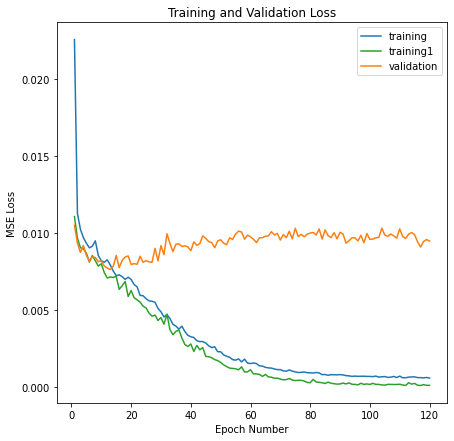

In [ ]:
train_data = get_data(data_path, tf_list, "train")
train_set = TFBindingDataset(train_data)
atcg_ratio = get_symbol_ratio(train_data['seq'])
weight = torch.from_numpy(get_pwm_list(data_path, tf_list, "_GM12878_4.wtmx", atcg_ratio))
 
train_set, val_set = random_split(train_set, [int(len(train_set)) - int(len(train_set)*validation_ratio), int(len(train_set)*validation_ratio)])    

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=True)
model = BindingPredictionCNN(weight)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print(model)
epoch_count = 120
train_log, train_log1, val_log = train(model, train_loader, val_loader, optimizer, criterion, device, epoch_count)
plot_loss(train_log, train_log1, val_log, epoch_count)

In [ ]:
torch.save(model.state_dict(), 'drive/My Drive/CS582-Project/Models/model')

##Testing

In [ ]:
def test(net, test_loader, device):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():
        for (x_input,labels) in tqdm(test_loader, desc='Test ', leave=False):
            x_input, labels = x_input.to(device), labels.to(device)
            outputs = net(x_input)
            y_true.extend(labels.float().detach().cpu().numpy())
            y_pred.extend(outputs.float().detach().cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

##Test Evaluation

In [ ]:
test_data = get_data(data_path, tf_list, "test")
test_set = TFBindingDataset(test_data)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                        shuffle=True)
y_true, y_pred = test(model, test_loader, device)

Test :   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print("Test MSE: ", mean_squared_error(y_true, y_pred))

Test MSE:  0.017090512


### Classification

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


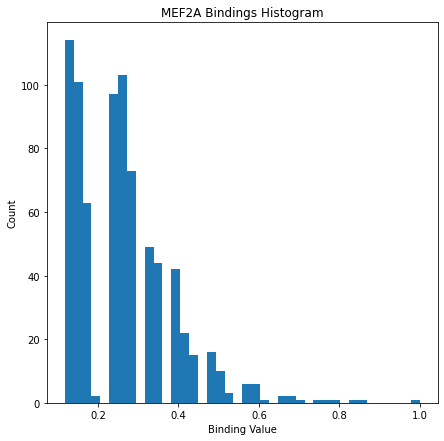

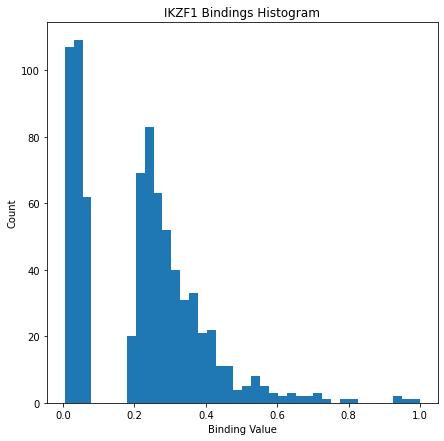

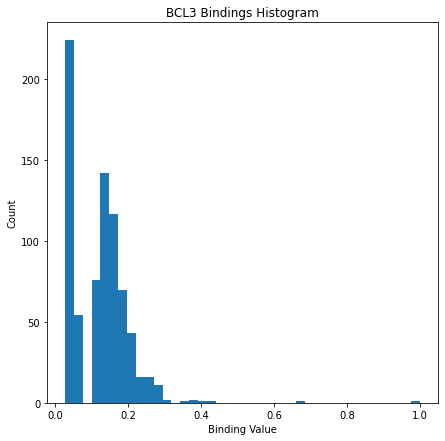

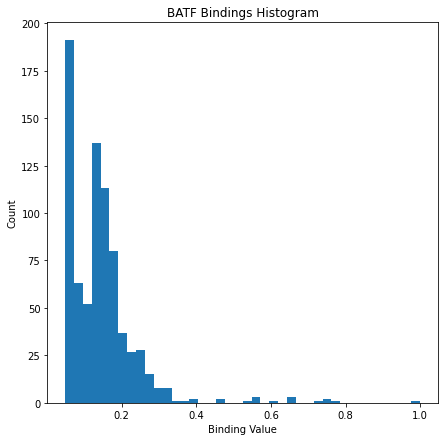

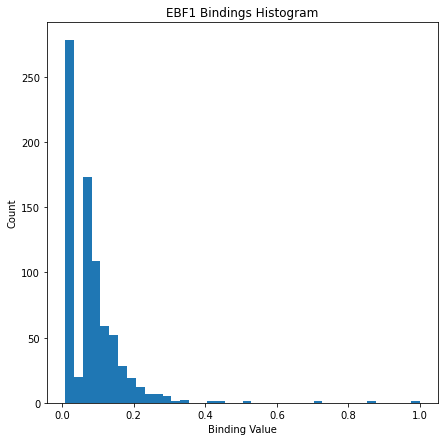

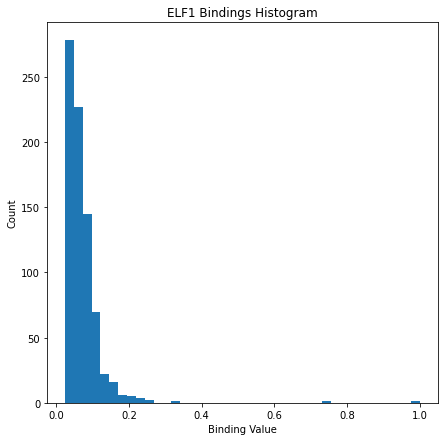

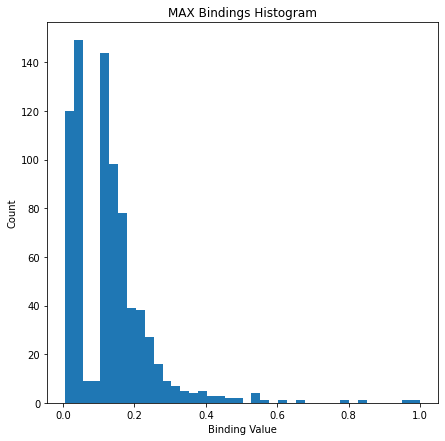

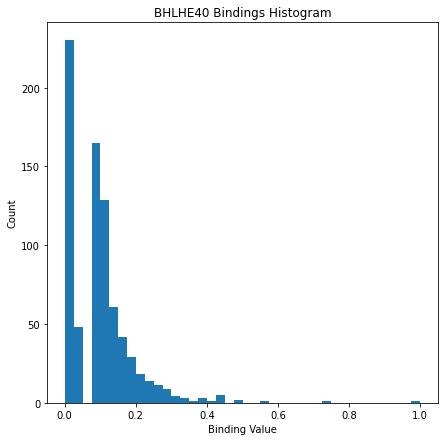

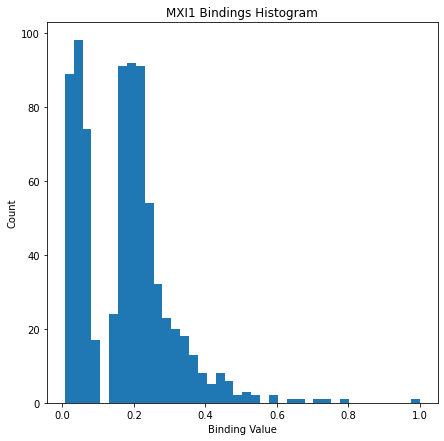

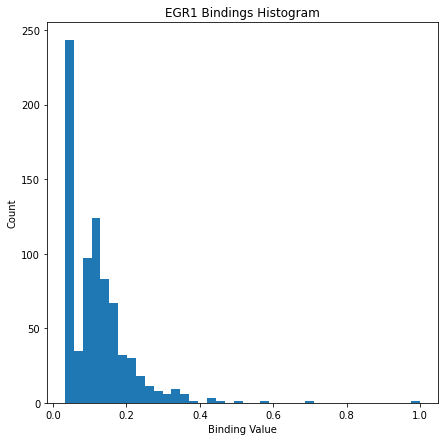

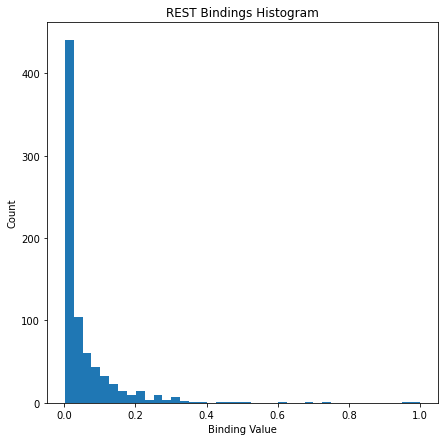

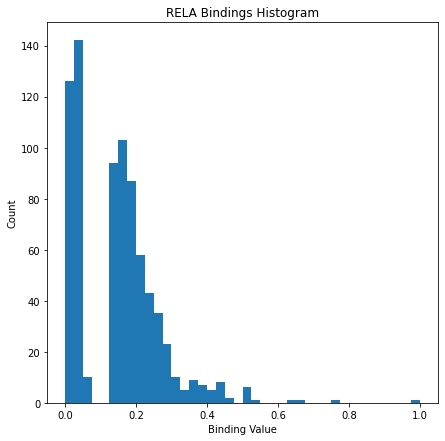

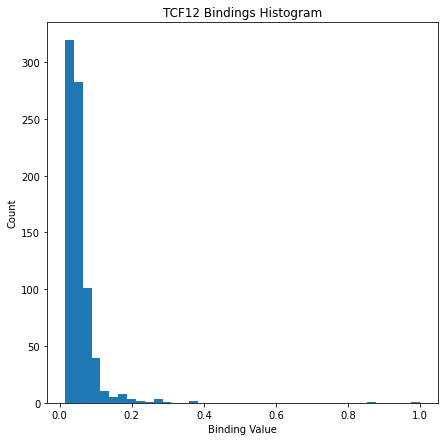

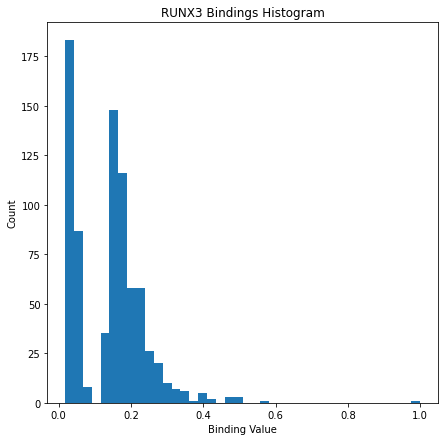

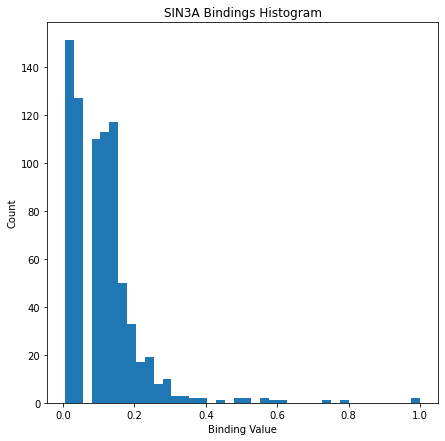

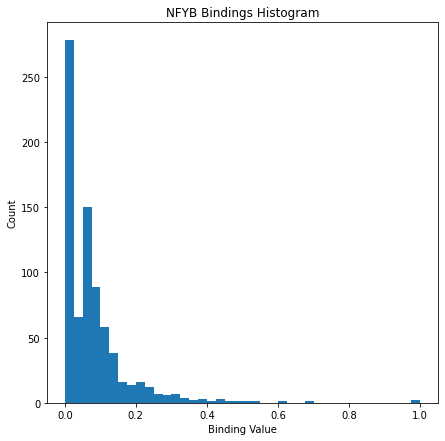

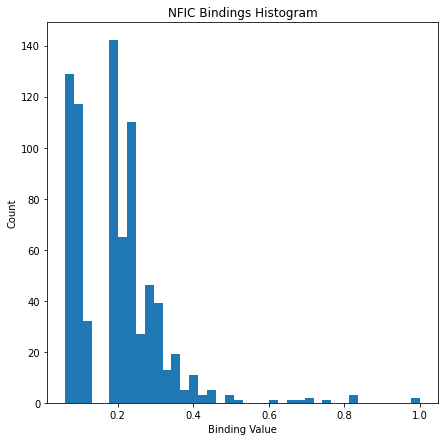

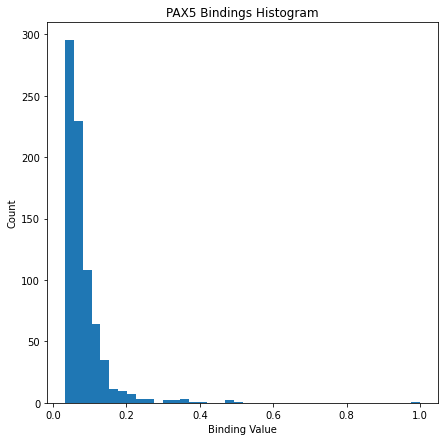

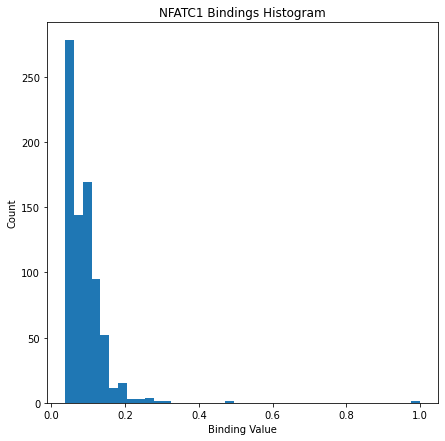

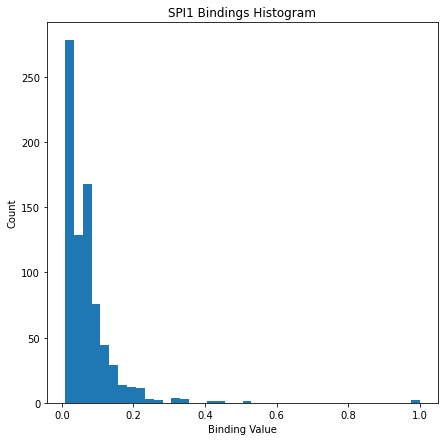

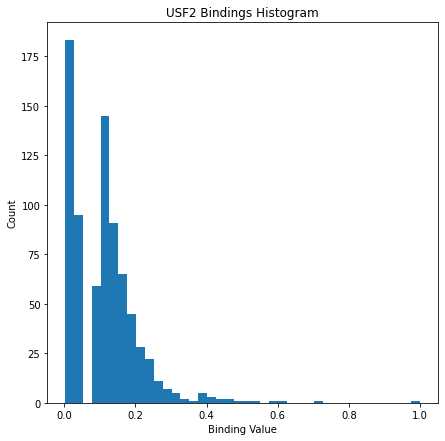

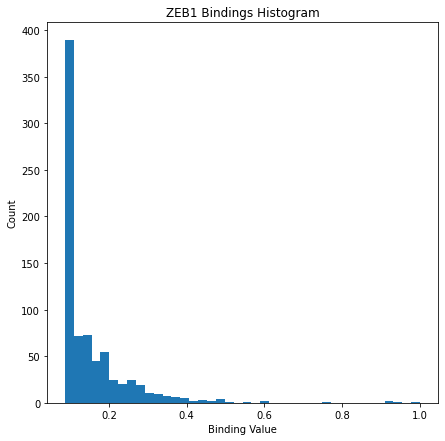

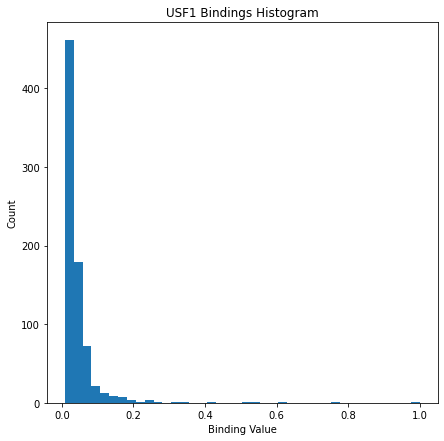

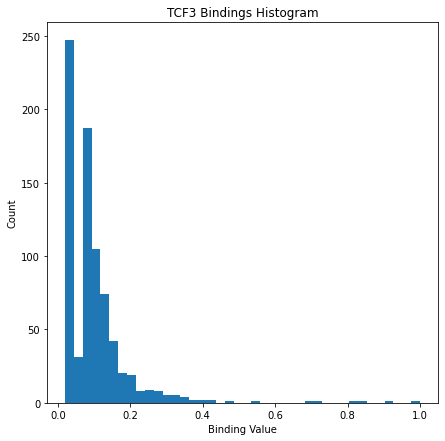

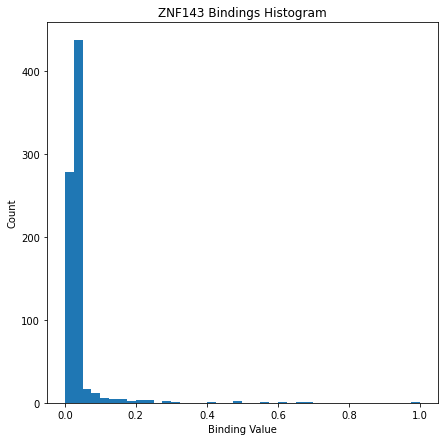

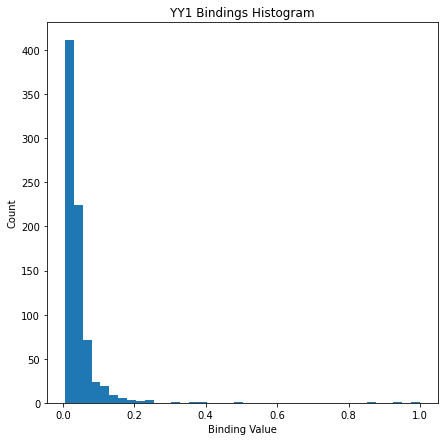

In [ ]:
plot_binding_histogram([train_loader, val_loader], tf_list)

In [ ]:
binding_dict = get_binding_values([train_loader, val_loader], tf_list)
#for (key, value) in binding_dict.items():
#  print(len(value))

In [ ]:
print(y_true.shape)
print(y_pred.shape)

(400, 26)
(400, 26)


================  MEF2A  ================
[[183  85]
 [ 59  73]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       268
           1       0.46      0.55      0.50       132

    accuracy                           0.64       400
   macro avg       0.61      0.62      0.61       400
weighted avg       0.66      0.64      0.65       400

=== Statistics ===
Test Accuracy: 0.640
Test Sensitivity: 0.553
Test Specificity: 0.683
Test F1-Score: 0.503


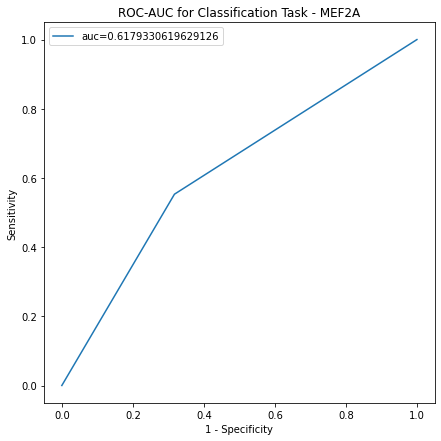

================  IKZF1  ================
[[164  86]
 [ 91  59]]
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       250
           1       0.41      0.39      0.40       150

    accuracy                           0.56       400
   macro avg       0.53      0.52      0.52       400
weighted avg       0.55      0.56      0.56       400

=== Statistics ===
Test Accuracy: 0.557
Test Sensitivity: 0.393
Test Specificity: 0.656
Test F1-Score: 0.400


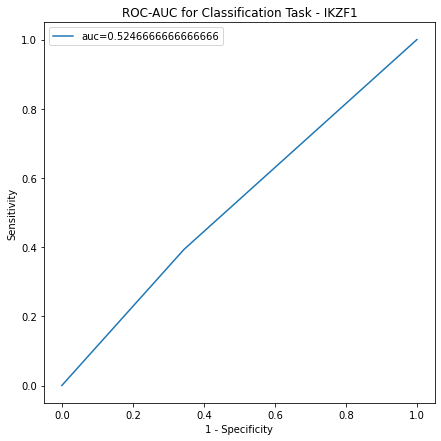

================  BCL3  ================
[[140  74]
 [120  66]]
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       214
           1       0.47      0.35      0.40       186

    accuracy                           0.52       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.51      0.52      0.50       400

=== Statistics ===
Test Accuracy: 0.515
Test Sensitivity: 0.355
Test Specificity: 0.654
Test F1-Score: 0.405


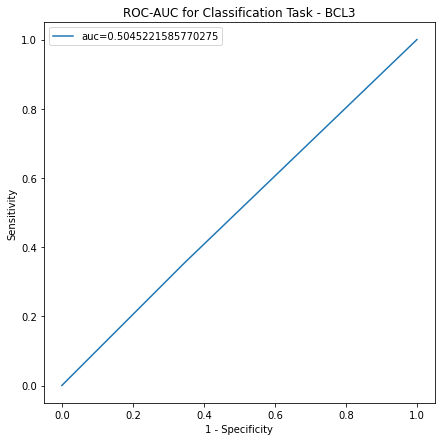

================  BATF  ================
[[214  99]
 [ 54  33]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.74       313
           1       0.25      0.38      0.30        87

    accuracy                           0.62       400
   macro avg       0.52      0.53      0.52       400
weighted avg       0.68      0.62      0.64       400

=== Statistics ===
Test Accuracy: 0.618
Test Sensitivity: 0.379
Test Specificity: 0.684
Test F1-Score: 0.301


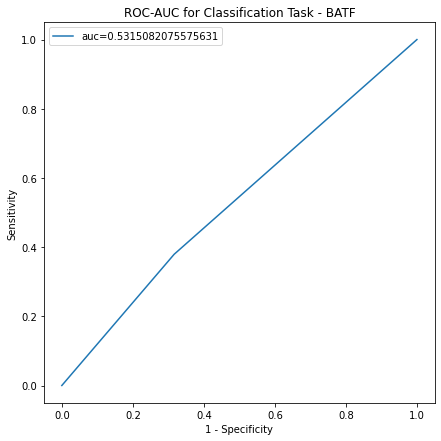

================  EBF1  ================
[[205  96]
 [ 74  25]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71       301
           1       0.21      0.25      0.23        99

    accuracy                           0.57       400
   macro avg       0.47      0.47      0.47       400
weighted avg       0.60      0.57      0.59       400

=== Statistics ===
Test Accuracy: 0.575
Test Sensitivity: 0.253
Test Specificity: 0.681
Test F1-Score: 0.227


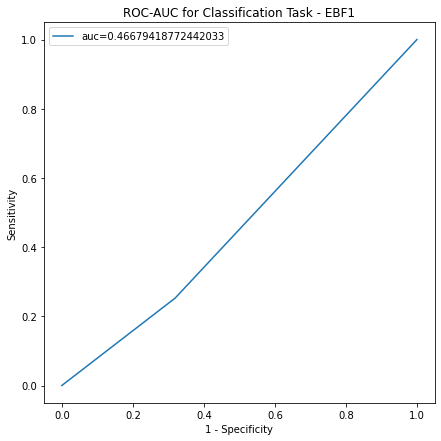

================  ELF1  ================
[[ 61  39]
 [193 107]]
              precision    recall  f1-score   support

           0       0.24      0.61      0.34       100
           1       0.73      0.36      0.48       300

    accuracy                           0.42       400
   macro avg       0.49      0.48      0.41       400
weighted avg       0.61      0.42      0.45       400

=== Statistics ===
Test Accuracy: 0.420
Test Sensitivity: 0.357
Test Specificity: 0.610
Test F1-Score: 0.480


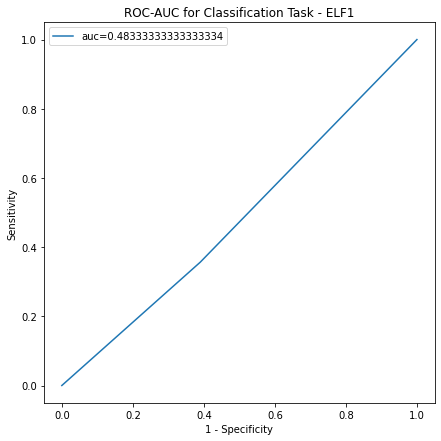

================  MAX  ================
[[144  76]
 [109  71]]
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       220
           1       0.48      0.39      0.43       180

    accuracy                           0.54       400
   macro avg       0.53      0.52      0.52       400
weighted avg       0.53      0.54      0.53       400

=== Statistics ===
Test Accuracy: 0.537
Test Sensitivity: 0.394
Test Specificity: 0.655
Test F1-Score: 0.434


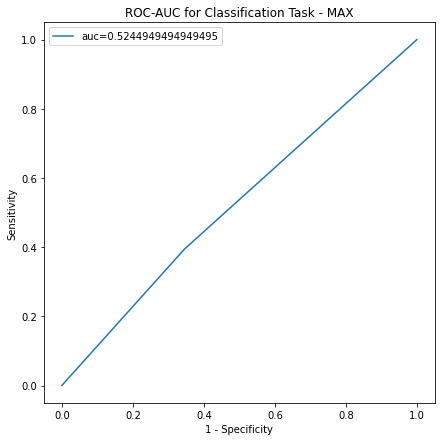

================  BHLHE40  ================
[[154  81]
 [109  56]]
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       235
           1       0.41      0.34      0.37       165

    accuracy                           0.53       400
   macro avg       0.50      0.50      0.49       400
weighted avg       0.51      0.53      0.52       400

=== Statistics ===
Test Accuracy: 0.525
Test Sensitivity: 0.339
Test Specificity: 0.655
Test F1-Score: 0.371


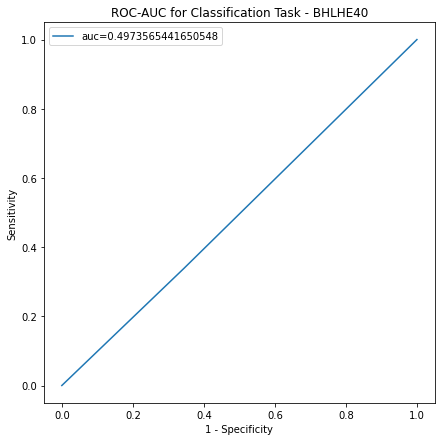

================  MXI1  ================
[[178 115]
 [ 57  50]]
              precision    recall  f1-score   support

           0       0.76      0.61      0.67       293
           1       0.30      0.47      0.37       107

    accuracy                           0.57       400
   macro avg       0.53      0.54      0.52       400
weighted avg       0.64      0.57      0.59       400

=== Statistics ===
Test Accuracy: 0.570
Test Sensitivity: 0.467
Test Specificity: 0.608
Test F1-Score: 0.368


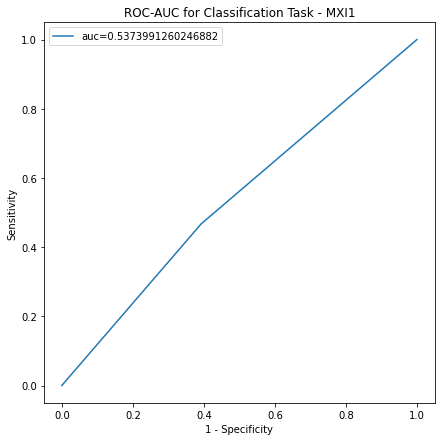

================  EGR1  ================
[[197 137]
 [ 40  26]]
              precision    recall  f1-score   support

           0       0.83      0.59      0.69       334
           1       0.16      0.39      0.23        66

    accuracy                           0.56       400
   macro avg       0.50      0.49      0.46       400
weighted avg       0.72      0.56      0.61       400

=== Statistics ===
Test Accuracy: 0.557
Test Sensitivity: 0.394
Test Specificity: 0.590
Test F1-Score: 0.227


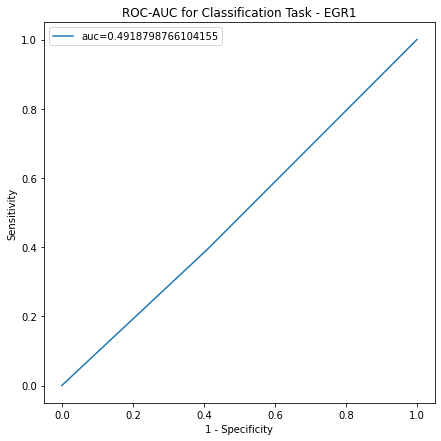

================  REST  ================
[[245 118]
 [ 19  18]]
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       363
           1       0.13      0.49      0.21        37

    accuracy                           0.66       400
   macro avg       0.53      0.58      0.49       400
weighted avg       0.85      0.66      0.73       400

=== Statistics ===
Test Accuracy: 0.657
Test Sensitivity: 0.486
Test Specificity: 0.675
Test F1-Score: 0.208


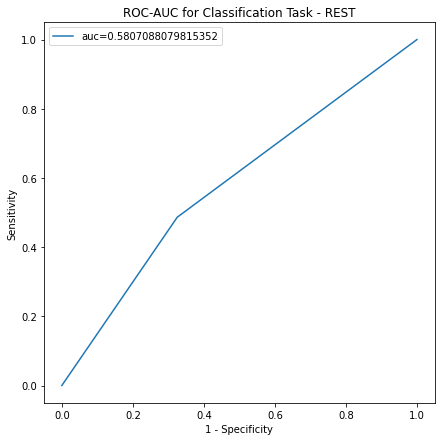

================  RELA  ================
[[237 106]
 [ 40  17]]
              precision    recall  f1-score   support

           0       0.86      0.69      0.76       343
           1       0.14      0.30      0.19        57

    accuracy                           0.64       400
   macro avg       0.50      0.49      0.48       400
weighted avg       0.75      0.64      0.68       400

=== Statistics ===
Test Accuracy: 0.635
Test Sensitivity: 0.298
Test Specificity: 0.691
Test F1-Score: 0.189


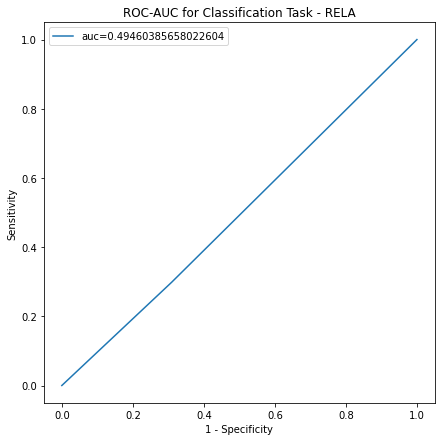

================  TCF12  ================
[[128  61]
 [151  60]]
              precision    recall  f1-score   support

           0       0.46      0.68      0.55       189
           1       0.50      0.28      0.36       211

    accuracy                           0.47       400
   macro avg       0.48      0.48      0.45       400
weighted avg       0.48      0.47      0.45       400

=== Statistics ===
Test Accuracy: 0.470
Test Sensitivity: 0.284
Test Specificity: 0.677
Test F1-Score: 0.361


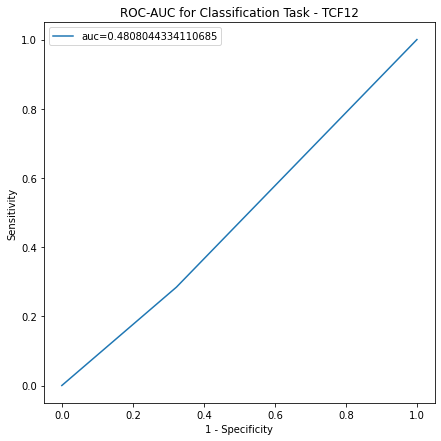

================  RUNX3  ================
[[178 114]
 [ 73  35]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.66       292
           1       0.23      0.32      0.27       108

    accuracy                           0.53       400
   macro avg       0.47      0.47      0.46       400
weighted avg       0.58      0.53      0.55       400

=== Statistics ===
Test Accuracy: 0.532
Test Sensitivity: 0.324
Test Specificity: 0.610
Test F1-Score: 0.272


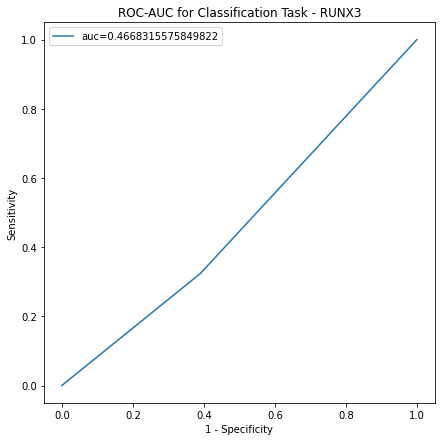

================  SIN3A  ================
[[206 122]
 [ 38  34]]
              precision    recall  f1-score   support

           0       0.84      0.63      0.72       328
           1       0.22      0.47      0.30        72

    accuracy                           0.60       400
   macro avg       0.53      0.55      0.51       400
weighted avg       0.73      0.60      0.64       400

=== Statistics ===
Test Accuracy: 0.600
Test Sensitivity: 0.472
Test Specificity: 0.628
Test F1-Score: 0.298


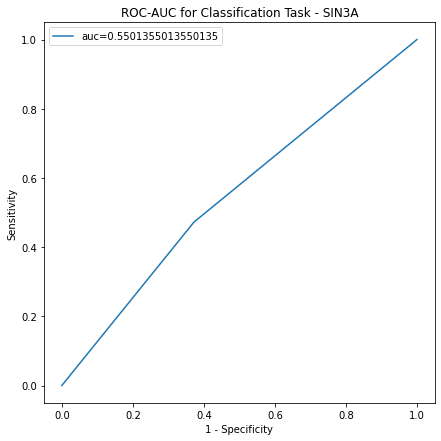

================  NFYB  ================
[[230 121]
 [ 29  20]]
              precision    recall  f1-score   support

           0       0.89      0.66      0.75       351
           1       0.14      0.41      0.21        49

    accuracy                           0.62       400
   macro avg       0.51      0.53      0.48       400
weighted avg       0.80      0.62      0.69       400

=== Statistics ===
Test Accuracy: 0.625
Test Sensitivity: 0.408
Test Specificity: 0.655
Test F1-Score: 0.211


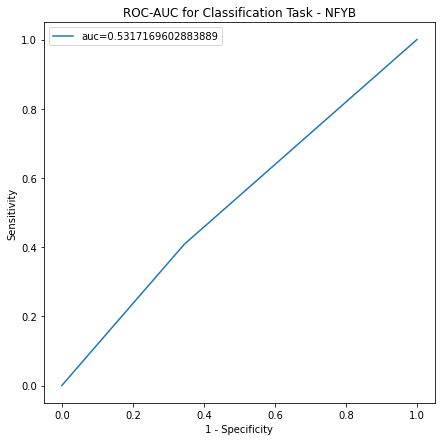

================  NFIC  ================
[[163  98]
 [ 94  45]]
              precision    recall  f1-score   support

           0       0.63      0.62      0.63       261
           1       0.31      0.32      0.32       139

    accuracy                           0.52       400
   macro avg       0.47      0.47      0.47       400
weighted avg       0.52      0.52      0.52       400

=== Statistics ===
Test Accuracy: 0.520
Test Sensitivity: 0.324
Test Specificity: 0.625
Test F1-Score: 0.319


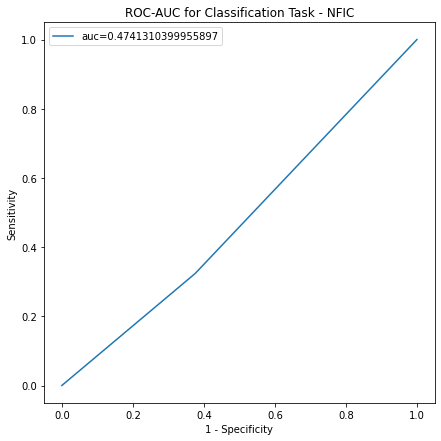

================  PAX5  ================
[[ 75  45]
 [177 103]]
              precision    recall  f1-score   support

           0       0.30      0.62      0.40       120
           1       0.70      0.37      0.48       280

    accuracy                           0.45       400
   macro avg       0.50      0.50      0.44       400
weighted avg       0.58      0.45      0.46       400

=== Statistics ===
Test Accuracy: 0.445
Test Sensitivity: 0.368
Test Specificity: 0.625
Test F1-Score: 0.481


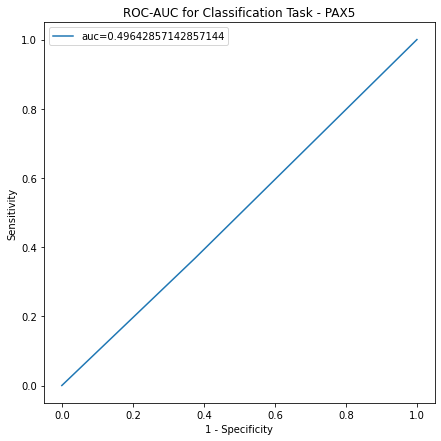

================  NFATC1  ================
[[183 119]
 [ 56  42]]
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       302
           1       0.26      0.43      0.32        98

    accuracy                           0.56       400
   macro avg       0.51      0.52      0.50       400
weighted avg       0.64      0.56      0.59       400

=== Statistics ===
Test Accuracy: 0.562
Test Sensitivity: 0.429
Test Specificity: 0.606
Test F1-Score: 0.324


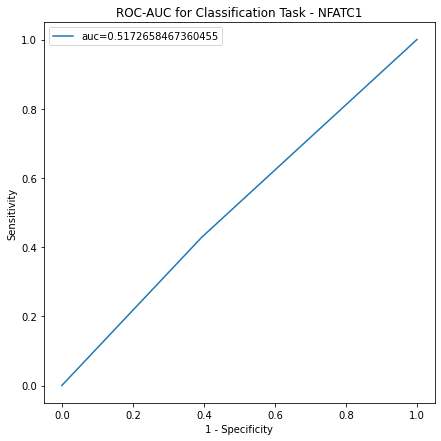

================  SPI1  ================
[[133  59]
 [124  84]]
              precision    recall  f1-score   support

           0       0.52      0.69      0.59       192
           1       0.59      0.40      0.48       208

    accuracy                           0.54       400
   macro avg       0.55      0.55      0.54       400
weighted avg       0.55      0.54      0.53       400

=== Statistics ===
Test Accuracy: 0.542
Test Sensitivity: 0.404
Test Specificity: 0.693
Test F1-Score: 0.479


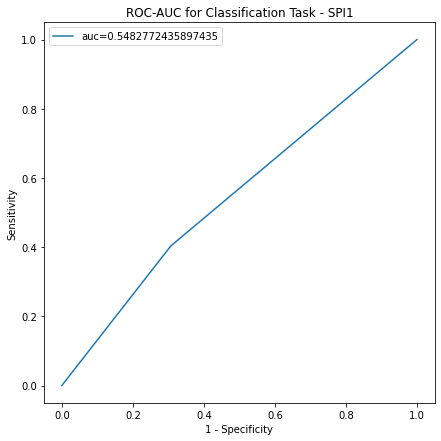

================  USF2  ================
[[129  70]
 [126  75]]
              precision    recall  f1-score   support

           0       0.51      0.65      0.57       199
           1       0.52      0.37      0.43       201

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.50       400
weighted avg       0.51      0.51      0.50       400

=== Statistics ===
Test Accuracy: 0.510
Test Sensitivity: 0.373
Test Specificity: 0.648
Test F1-Score: 0.434


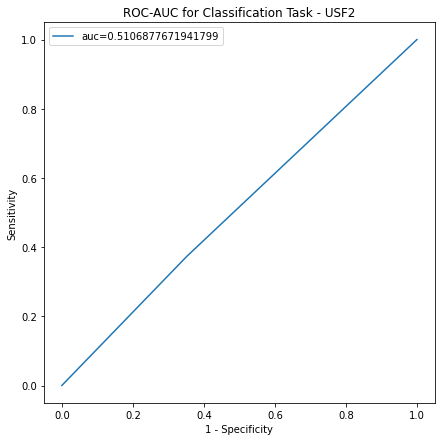

================  ZEB1  ================
[[185  80]
 [ 87  48]]
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       265
           1       0.38      0.36      0.37       135

    accuracy                           0.58       400
   macro avg       0.53      0.53      0.53       400
weighted avg       0.58      0.58      0.58       400

=== Statistics ===
Test Accuracy: 0.583
Test Sensitivity: 0.356
Test Specificity: 0.698
Test F1-Score: 0.365


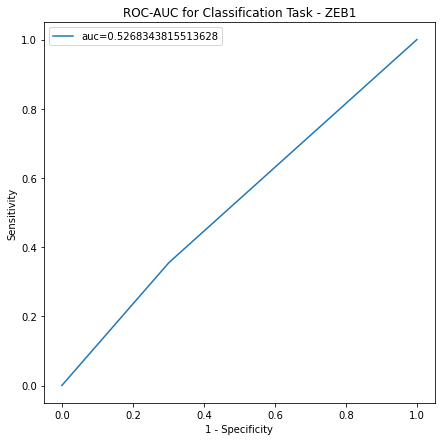

================  USF1  ================
[[215  98]
 [ 62  25]]
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       313
           1       0.20      0.29      0.24        87

    accuracy                           0.60       400
   macro avg       0.49      0.49      0.48       400
weighted avg       0.65      0.60      0.62       400

=== Statistics ===
Test Accuracy: 0.600
Test Sensitivity: 0.287
Test Specificity: 0.687
Test F1-Score: 0.238


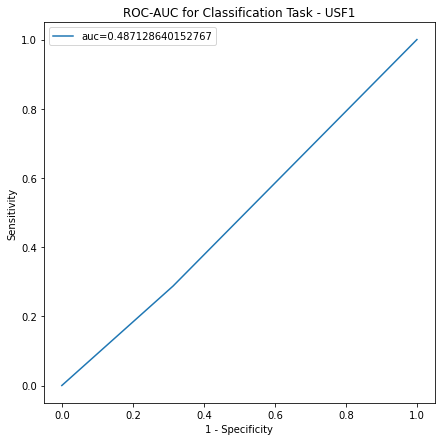

================  TCF3  ================
[[151  71]
 [130  48]]
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       222
           1       0.40      0.27      0.32       178

    accuracy                           0.50       400
   macro avg       0.47      0.47      0.46       400
weighted avg       0.48      0.50      0.48       400

=== Statistics ===
Test Accuracy: 0.497
Test Sensitivity: 0.270
Test Specificity: 0.680
Test F1-Score: 0.323


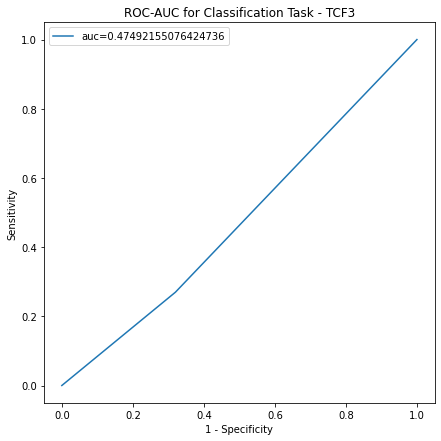

================  ZNF143  ================
[[227 114]
 [ 43  16]]
              precision    recall  f1-score   support

           0       0.84      0.67      0.74       341
           1       0.12      0.27      0.17        59

    accuracy                           0.61       400
   macro avg       0.48      0.47      0.46       400
weighted avg       0.73      0.61      0.66       400

=== Statistics ===
Test Accuracy: 0.608
Test Sensitivity: 0.271
Test Specificity: 0.666
Test F1-Score: 0.169


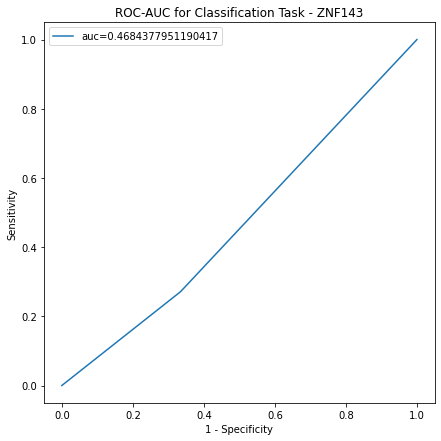

================  YY1  ================
[[180  87]
 [ 89  44]]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       267
           1       0.34      0.33      0.33       133

    accuracy                           0.56       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.56      0.56      0.56       400

=== Statistics ===
Test Accuracy: 0.560
Test Sensitivity: 0.331
Test Specificity: 0.674
Test F1-Score: 0.333


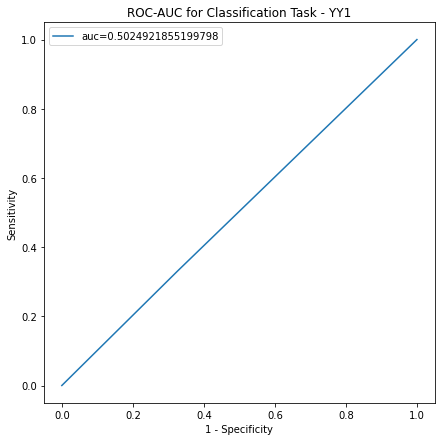

In [ ]:
for i in range(len(tf_list)):
  tf = tf_list[i]
  print("================ ", tf, " ================")
  binding_threshold = np.average(binding_dict[tf])
  y_pred_binary = (y_pred[:, i] > binding_threshold) * 1
  y_true_binary = (y_true[:, i] > binding_threshold) * 1
  #print(y_true_binary)
  classification_statistics(y_true_binary, y_pred_binary)
  roc_auc_curve_plot(y_true_binary,  y_pred_binary, tf)